# Let's play with Bedrock!

We'll start by importing all the libraries that we need and creating a connection to Bedrock.

In [1]:
# Import the base libraries
import boto3
import json
import base64
from botocore.config import Config
from botocore.exceptions import ClientError
from io import BytesIO
from base64 import b64encode
from base64 import b64decode

#Create the connection to Bedrock
bedrock_runtime = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-west-2',
)

bedrock = boto3.client(
    service_name='bedrock',
    region_name='us-west-2',
)

### Let's try and see how Claude describes an what a cat in a room looks like

In [58]:
def generate_message(bedrock_runtime, model_id, messages, max_tokens=512,top_p=1,temp=0.5,system=''):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p,
            "system": system
        }  
    )  
    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())

    return response_body

messages=[{ "role":'user', "content":[{'type':'text','text': "What does a cat in a room look like? Describe in 20 words or less."}]}]

generate_message(bedrock_runtime, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=messages,max_tokens=512,temp=0.5,top_p=0.9)

{'id': 'msg_01HZ178VHPmkZdcEhcNnfs9S',
 'type': 'message',
 'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'A furry feline creature, gracefully lounging or prowling, with alert eyes and twitching tail.'}],
 'model': 'claude-3-sonnet-28k-20240229',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 27, 'output_tokens': 27}}

### Now, let's use stable diffusion to generate an image of the description that Claude generated

In [59]:
from PIL import Image

# Define prompt and model parameters
prompt_data = """A furry feline creature, gracefully lounging or prowling, with alert eyes and twitching tail."""

body = json.dumps({"text_prompts":[{"text":prompt_data}],
  "cfg_scale":6,
  "seed":10,
  "steps":50}) 

modelId = 'stability.stable-diffusion-xl-v1'
accept = 'application/json'
contentType = 'application/json'

response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response = json.loads(response.get('body').read())
images = response.get('artifacts')

image = Image.open(BytesIO(b64decode(images[0].get('base64'))))
image.save("generated_image.png")



## Show the image that was generated

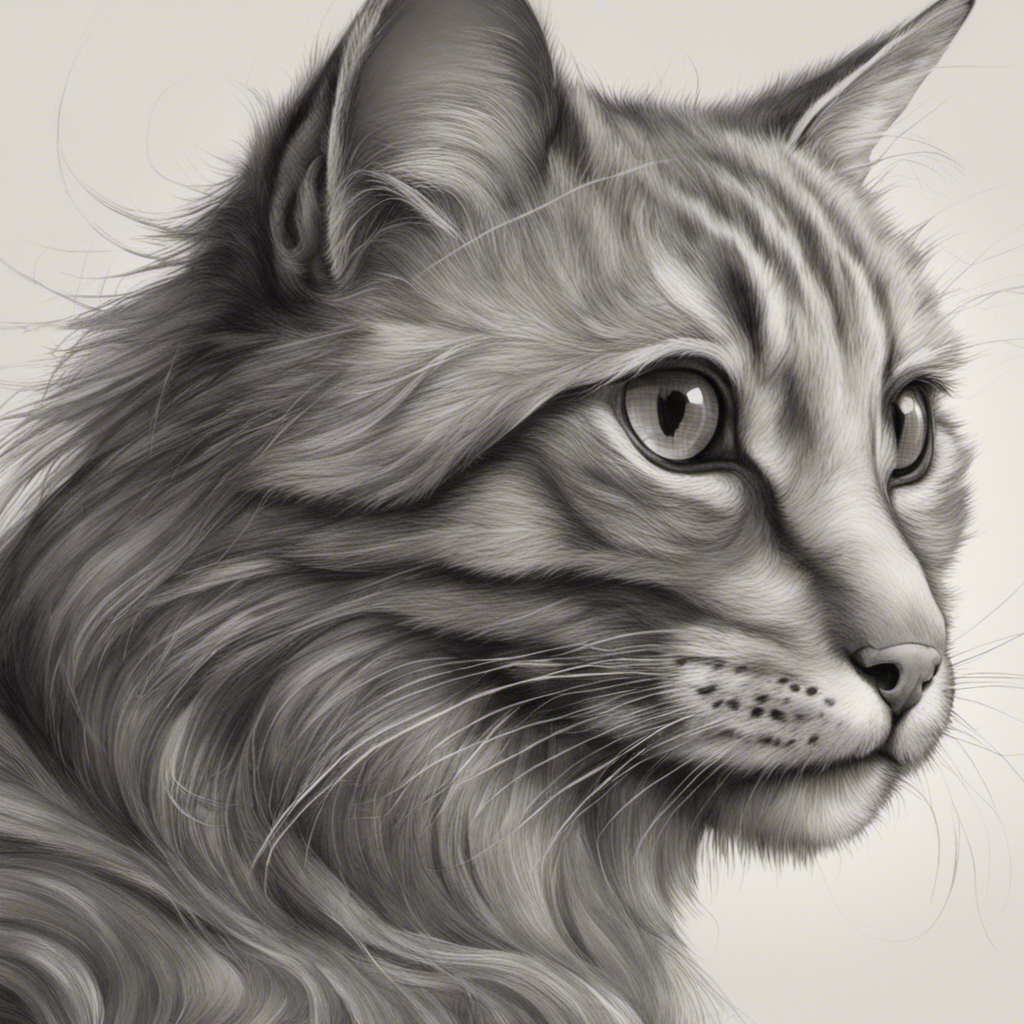

In [60]:
from IPython.display import Image
Image(filename='generated_image.png') 

### Now, let's ask claude what is in the image that was generated by stable diffusion

In [61]:
with open("generated_image.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    base64_string = encoded_string.decode('utf-8')

payload = {
    "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    "contentType": "application/json",
    "accept": "application/json",
    "body": {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": base64_string
                        }
                    },
                    {
                        "type": "text",
                        "text": "Write me a short description of this photo, 20 words or less."
                    }
                ]
            }
        ]
    }
}

# Convert the payload to bytes
body_bytes = json.dumps(payload['body']).encode('utf-8')

# Invoke the model
response = bedrock_runtime.invoke_model(
    body=body_bytes,
    contentType=payload['contentType'],
    accept=payload['accept'],
    modelId=payload['modelId']
)

# Process the response
response_body = response['body'].read().decode('utf-8')
json_object = json.loads(response_body)
claude_response = json.dumps(json_object, indent=2)

print(claude_response)

{
  "id": "msg_01AebKU24yo6fvsv5DGksb3r",
  "type": "message",
  "role": "assistant",
  "content": [
    {
      "type": "text",
      "text": "This detailed graphite drawing portrays a lifelike close-up of a feline's face, exquisitely capturing the textured fur patterns and intense, piercing gaze of its expressive eyes. The shading and high contrast create a striking, almost sculptural depiction of the majestic creature's facial features and whiskers."
    }
  ],
  "model": "claude-3-sonnet-28k-20240229",
  "stop_reason": "end_turn",
  "stop_sequence": null,
  "usage": {
    "input_tokens": 1425,
    "output_tokens": 74
  }
}


### Now let's turn the cat into a dog!

Stable Diffusion let's us do some interesting stuff with our images like changing characters or modifying scenery etc.

In [62]:
#

from PIL import Image

prompt_data = """Change the character into a dog"""

buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps({"text_prompts":[{"text": prompt_data }], "init_image": base64.b64encode(img_bytes).decode()})
modelId = 'stability.stable-diffusion-xl-v1'

try: 
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)
 
if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'converted.png'

#save file
image.save(file_name)

## Show the new image that was generated

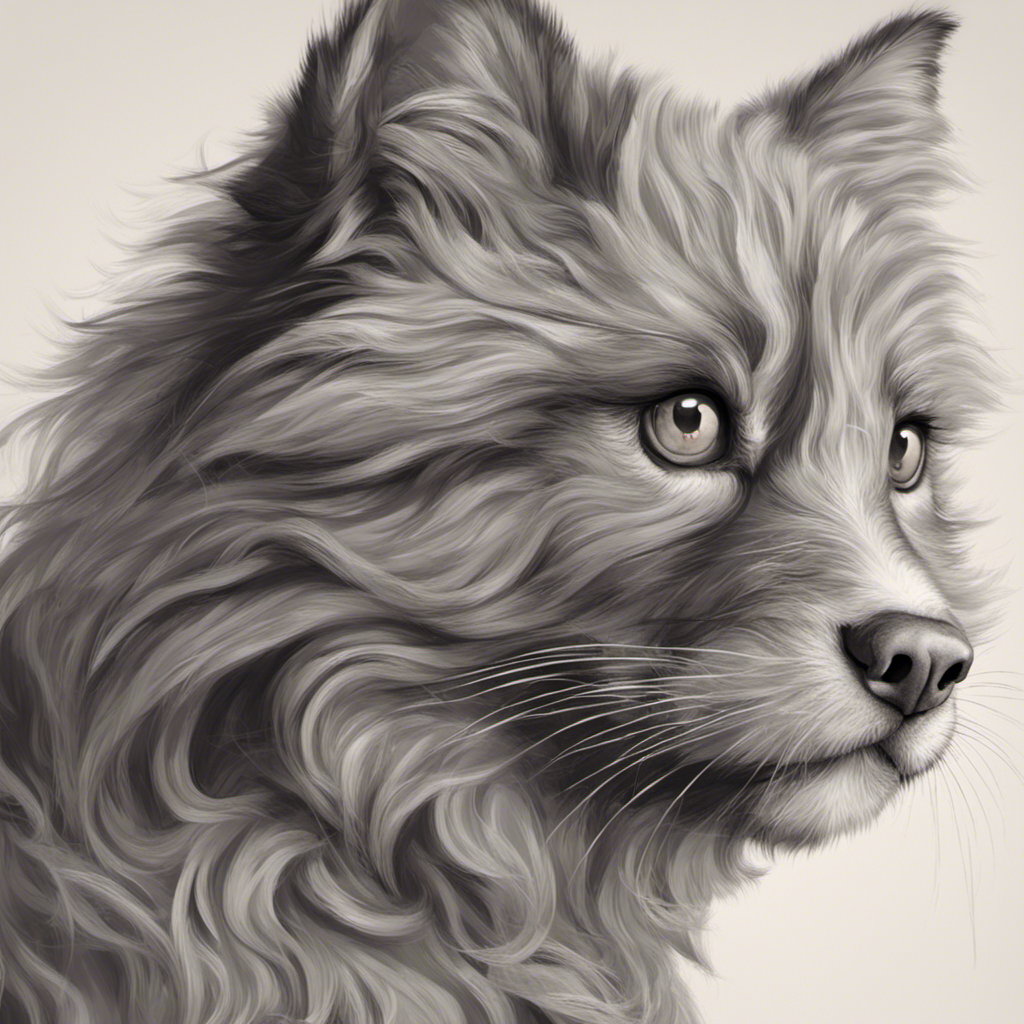

In [63]:
from IPython.display import Image
Image(filename='converted.png') 

### Now, let's ask claude what is in the new image

In [66]:
with open("converted.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    base64_string = encoded_string.decode('utf-8')

payload = {
    "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    "contentType": "application/json",
    "accept": "application/json",
    "body": {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": base64_string
                        }
                    },
                    {
                        "type": "text",
                        "text": "Write me a short description of this photo, 25 words or less."
                    }
                ]
            }
        ]
    }
}

# Convert the payload to bytes
body_bytes = json.dumps(payload['body']).encode('utf-8')

# Invoke the model
response = bedrock_runtime.invoke_model(
    body=body_bytes,
    contentType=payload['contentType'],
    accept=payload['accept'],
    modelId=payload['modelId']
)

# Process the response
response_body = response['body'].read().decode('utf-8')
json_object = json.loads(response_body)
claude_response = json.dumps(json_object, indent=2)

print(claude_response)

{
  "id": "msg_01NDKbPPHc3eSxLVG2xS2ZCL",
  "type": "message",
  "role": "assistant",
  "content": [
    {
      "type": "text",
      "text": "This striking illustration depicts a dog with incredibly detailed, swirling fur patterns in shades of gray, showcasing its expressive eyes and features with remarkable realism."
    }
  ],
  "model": "claude-3-sonnet-28k-20240229",
  "stop_reason": "end_turn",
  "stop_sequence": null,
  "usage": {
    "input_tokens": 1425,
    "output_tokens": 37
  }
}


#### That was fun!